In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [3]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [4]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///../Resources/hawaii.sqlite")

In [5]:
# reflect an existing database into a new model
Base = automap_base()

# reflect the tables
Base.prepare(autoload_with=engine)


In [6]:
# View all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [7]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station


In [8]:
# Create our session (link) from Python to the DB
session = Session(bind=engine)

# Exploratory Precipitation Analysis

In [9]:
# Find the most recent date in the data set.
mostrecent = session.query(func.max(Measurement.date)).first()
mostrecent

('2017-08-23',)

Text(0, 0.5, 'Inches')

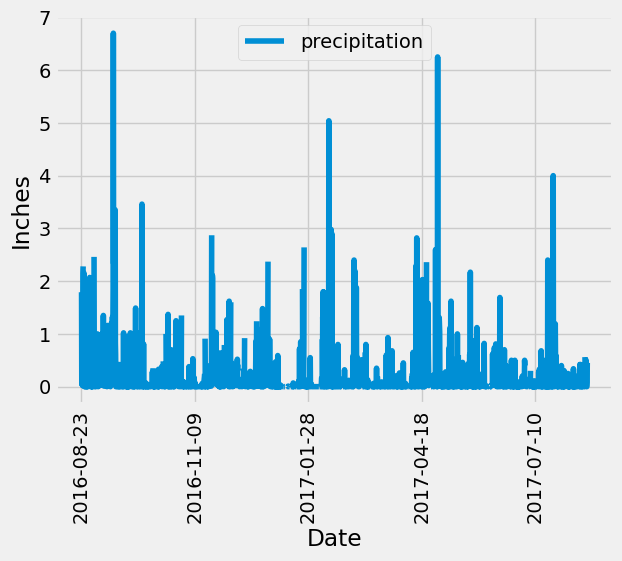

In [10]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Starting from the most recent data point in the database. 

# Calculate the date one year from the last date in data set.
oneyearback = dt.date(2017, 8, 23) - dt.timedelta(days=365)

# Perform a query to retrieve the data and precipitation scores
datascores = session.query(Measurement.date, Measurement.prcp).filter(Measurement.date >= oneyearback).all()

# Save the query results as a Pandas DataFrame. Explicitly set the column names
dataframe = pd.DataFrame(datascores, columns=['date', 'precipitation'])

# Sort the dataframe by date
dataframe = dataframe.sort_values('date')

# Use Pandas Plotting with Matplotlib to plot the data
dataframe.plot(x='date', y='precipitation', rot=90)
plt.xlabel('Date')
plt.ylabel('Inches')

In [11]:
# Use Pandas to calculate the summary statistics for the precipitation data
dataframe.describe()

,precipitation
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


# Exploratory Station Analysis

In [12]:
# Design a query to calculate the total number of stations in the dataset
stations = session.query(func.count(Station.id)).all()
stations

[(9,)]

In [17]:
# Design a query to find the most active stations (i.e. which stations have the most rows?)
# List the stations and their counts in descending order.

station_counts = session.query(Station.station, Station.name, func.count(Measurement.id).label('count')) \
    .join(Measurement, Station.station == Measurement.station) \
    .group_by(Station.station, Station.name) \
    .order_by(func.count(Measurement.id).desc()) \
    .all()

#this will print it in the basic query output
#station_counts

#it will look like this:  
""" 
[('USC00519281', 'WAIHEE 837.5, HI US', 2772),
 ('USC00519397', 'WAIKIKI 717.2, HI US', 2724),
 ('USC00513117', 'KANEOHE 838.1, HI US', 2709),
 ('USC00519523', 'WAIMANALO EXPERIMENTAL FARM, HI US', 2669),
 ('USC00516128', 'MANOA LYON ARBO 785.2, HI US', 2612),
 ('USC00514830', 'KUALOA RANCH HEADQUARTERS 886.9, HI US', 2202),
 ('USC00511918', 'HONOLULU OBSERVATORY 702.2, HI US', 1979),
 ('USC00517948', 'PEARL CITY, HI US', 1372),
 ('USC00518838', 'UPPER WAHIAWA 874.3, HI US', 511)] 
 """

#i however prefer the prettier formatting
for station, name, count in station_counts:
    print(f"Station: {station} ({name}) Occured this many times: {count}")

Station: USC00519281 (WAIHEE 837.5, HI US) Occured this many times: 2772
Station: USC00519397 (WAIKIKI 717.2, HI US) Occured this many times: 2724
Station: USC00513117 (KANEOHE 838.1, HI US) Occured this many times: 2709
Station: USC00519523 (WAIMANALO EXPERIMENTAL FARM, HI US) Occured this many times: 2669
Station: USC00516128 (MANOA LYON ARBO 785.2, HI US) Occured this many times: 2612
Station: USC00514830 (KUALOA RANCH HEADQUARTERS 886.9, HI US) Occured this many times: 2202
Station: USC00511918 (HONOLULU OBSERVATORY 702.2, HI US) Occured this many times: 1979
Station: USC00517948 (PEARL CITY, HI US) Occured this many times: 1372
Station: USC00518838 (UPPER WAHIAWA 874.3, HI US) Occured this many times: 511


In [21]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.

#To match your output EXACTLY I did it this way:
""" result = session.query(
        func.min(Measurement.tobs),
        func.max(Measurement.tobs),
        func.avg(Measurement.tobs)).filter(Measurement.station == 'USC00519281').first()

result
#this shows: (54.0, 85.0, 71.66378066378067)
"""

#however I find this is much nicer looking:  
lowest = session.query(func.min(Measurement.tobs)).filter(Measurement.station == 'USC00519281').first()
maximum = session.query(func.max(Measurement.tobs)).filter(Measurement.station == 'USC00519281').first()
average = session.query(func.avg(Measurement.tobs)).filter(Measurement.station == 'USC00519281').first()

print(f"Station ID: USC00519281")
print(f"Lowest Temp: {lowest}")
print(f"Maximum Temp: {maximum}")
print(f"Average Temp: {average}")

Station ID: USC00519281
Lowest Temp: (54.0,)
Maximum Temp: (85.0,)
Average Temp: (71.66378066378067,)


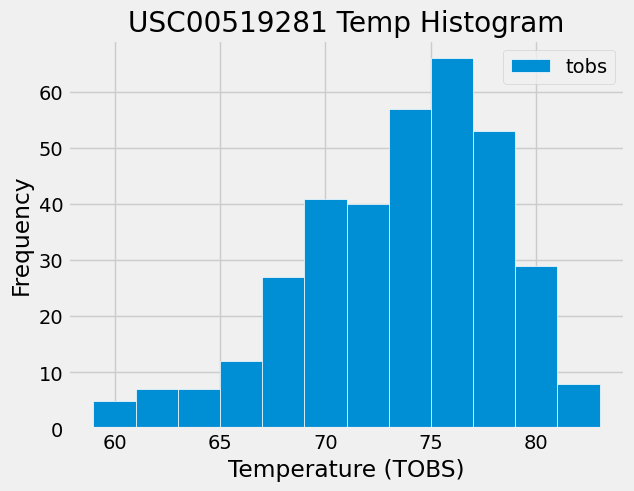

In [15]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram

oneyearback = dt.date(2017, 8, 23) - dt.timedelta(days=365)

station_id = 'USC00519281'

results = session.query(Measurement.tobs).filter(
    Measurement.station == station_id, 
    Measurement.date >= oneyearback
    ).all()

df = pd.DataFrame(results, columns=['tobs'])

plt.hist(df['tobs'], bins=12, edgecolor='white', label='tobs')
plt.legend()
plt.xlabel('Temperature (TOBS)')
plt.ylabel('Frequency')
plt.title('USC00519281 Temp Histogram')
plt.show()

# Close Session

In [16]:
# Close Session
session.close()